In [1]:
!gdown 116lNERV_fDJS8-Fx_pRv5qefqyUUHOFt

Downloading...
From: https://drive.google.com/uc?id=116lNERV_fDJS8-Fx_pRv5qefqyUUHOFt
To: /content/Sentiment Analysis.zip
100% 592k/592k [00:00<00:00, 22.4MB/s]


In [2]:
!unzip "Sentiment Analysis.zip"

Archive:  Sentiment Analysis.zip
  inflating: Sentiment Analysis/sample_submission_LnhVWA4.csv  
  inflating: Sentiment Analysis/test_oJQbWVk.csv  
  inflating: Sentiment Analysis/train_2kmZucJ.csv  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_df=pd.read_csv("/content/Sentiment Analysis/train_2kmZucJ.csv")

In [30]:
train_df[train_df['label']==1]     # SO NEGATIVE IS 1 AND POSITIVE IS 0

,id,label,tweet
4,5,1,What amazing service! Apple won't even talk to...
5,6,1,iPhone software update fucked up my phone big ...
10,11,1,hey #apple when you make a new ipod dont make ...
11,12,1,Ha! Not heavy machinery but it does what I nee...
12,13,1,Contemplating giving in to the iPhone bandwago...
...,...,...,...
7901,7902,1,@brendan_brady1: The new apple advert can fuck...
7902,7903,1,All I wanna do is put music from my iTunes on ...
7904,7905,1,#FuckYou #Apple one thing stops working and I ...
7908,7909,1,SECOND FUCKING TIME. Stay on hold for 30 mins ...


In [5]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
#from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
!pip install datasets transformers==4.28.0
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 18.2 MB/s eta 0:00:00


In [8]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [9]:
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

In [ ]:
pred_texts = list(train_df['tweet'])
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)
predictions = trainer.predict(pred_dataset)
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map({1: 'POSITIVE', 0: 'NEGATIVE'})
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)
df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores)), columns=['text','pred','label','score'])

In [33]:
df['pred']=abs(1-df['pred'])     # SWAPPING 1,0 by taking absolute value and subtracting value of column as in our case NEGATIVE is 1 and POSITIVE is 0
from sklearn.metrics import accuracy_score
accuracy_score(train_df['label'], df['pred'])

0.8904040404040404

roBERTa gave us 89% accuracy

In [39]:
df.head()

,text,pred,label,score
0,#fingerprint #Pregnancy Test https://goo.gl/h1...,0,POSITIVE,0.998101
1,Finally a transparant silicon case ^^ Thanks t...,0,POSITIVE,0.998755
2,We love this! Would you go? #talk #makememorie...,0,POSITIVE,0.998867
3,I'm wired I know I'm George I was made that wa...,0,POSITIVE,0.998247
4,What amazing service! Apple won't even talk to...,1,NEGATIVE,0.999000


In [40]:
test_df=pd.read_csv("/content/Sentiment Analysis/test_oJQbWVk.csv")

In [41]:
test_df

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...
...,...,...
1948,9869,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old..."
1949,9870,Now Available - Hoodie. Check it out here - ht...
1950,9871,There goes a crack right across the screen. If...
1951,9872,@codeofinterest as i said #Adobe big time we m...


In [44]:
pred_texts = list(test_df['tweet'])
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)
predictions = trainer.predict(pred_dataset)
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map({1: 'POSITIVE', 0: 'NEGATIVE'})
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)
output_df = pd.DataFrame(list(zip(list(test_df['id']),preds)), columns=['id','label'])

In [49]:
output_df['label']=abs(1-output_df['label'])   # SWAPPING 1,0 by taking absolute value of (1 - value in column) as in our case NEGATIVE is 1 and POSITIVE is 0

In [50]:
output_df

,id,label
0,7921,1
1,7922,1
2,7923,0
3,7924,1
4,7925,1
...,...,...
1948,9869,1
1949,9870,0
1950,9871,1
1951,9872,1


In [52]:
output_df.to_csv('output.csv')

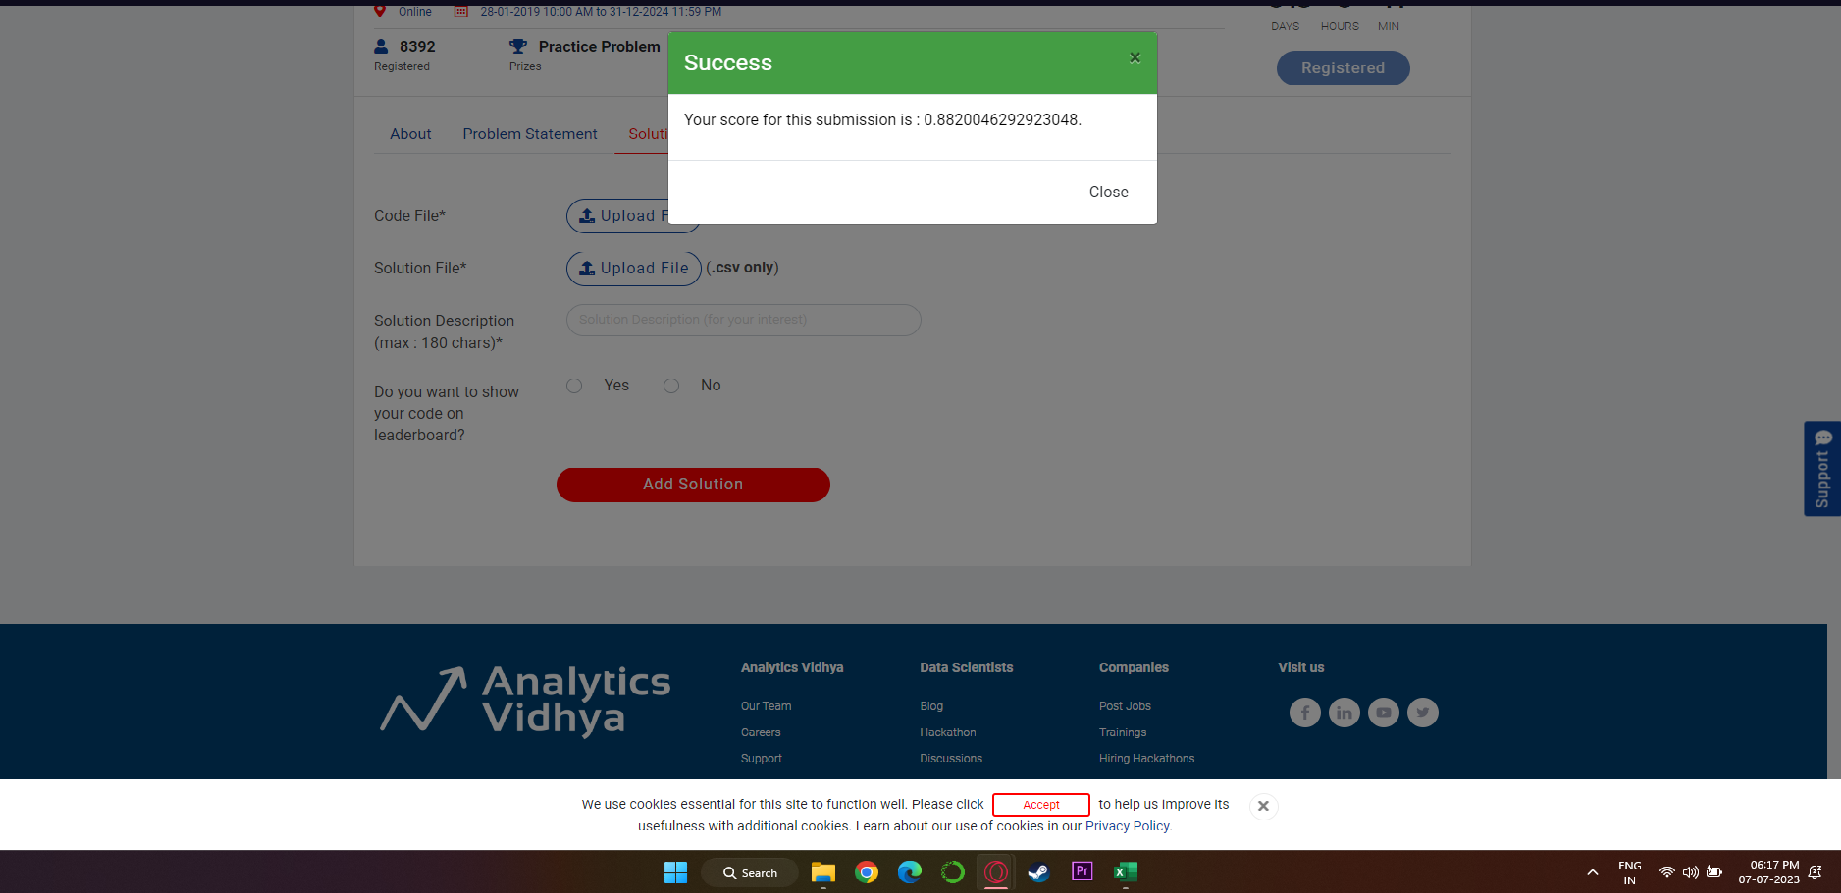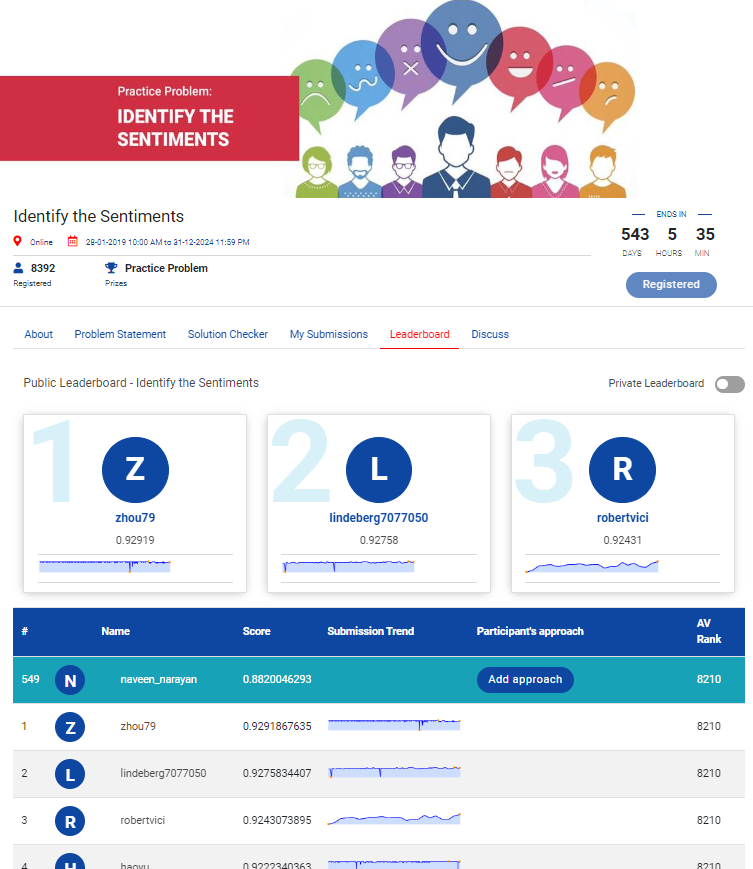